In [35]:
# Module Imports
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm
import time

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import os
import random
import shutil

import importlib.util

# Movenet Thunder and Python Pose Estimation
sys.path.append('./TF-Movenet/examples/lite/examples/pose_estimation/raspberry_pi')

import utils
from data import BodyPart
from ml import Movenet

movenet = Movenet('./TF-Movenet/movenet_thunder')

In [36]:
# Find Person Within Input Image
def detect(input_tensor, inference_count=3):
    image_height, image_width, channel = input_tensor.shape

    movenet.detect(input_tensor.numpy(), reset_crop_region=True)

    for _ in range(inference_count - 1):
        person = movenet.detect(input_tensor.numpy(), reset_crop_region=False)

    return person

In [37]:
# Draw Pose Estimation on Image
def draw_prediction_on_image(image, person, crop_region=None, close_figure=True, keep_input_size=False):
    image_np = utils.visualize(image, [person])

    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    im = ax.imshow(image_np)

    if close_figure:
        plt.close(fig)

    if not keep_input_size:
        image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

    return image_np

In [38]:
class MoveNetPreprocessor(object):

    def __init__(self, images_in_folder, images_out_folder, csvs_out_path):
        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_path = csvs_out_path
        self._messages = []

        # Create a temp dir to store the pose CSVs per class
        self._csvs_out_folder_per_class = tempfile.mkdtemp()

        # Get list of pose classes and print image statistics
        self._pose_class_names = sorted([n for n in os.listdir(self._images_in_folder) if not n.startswith('.')])

    # Preprocess Images in Given Folder
    def process(self, per_pose_class_limit=None, detection_threshold=0.1):

        # Loop through the classes and preprocess its images
        for pose_class_name in self._pose_class_names:
            print('Preprocessing', pose_class_name, file=sys.stderr)

            # Paths for the pose class.
            images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
            images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, pose_class_name + '.csv')
            if not os.path.exists(images_out_folder):
                os.makedirs(images_out_folder)

            # Detect landmarks in each image and write it to a CSV file
            with open(csv_out_path, 'w') as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file, 
                                            delimiter=',', 
                                            quoting=csv.QUOTE_MINIMAL)
                # Get list of images
                image_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
                if per_pose_class_limit is not None:
                    image_names = image_names[:per_pose_class_limit]

                valid_image_count = 0

                # Detect pose landmarks from each image
                for image_name in tqdm.tqdm(image_names):
                    image_path = os.path.join(images_in_folder, image_name)

                    try:
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                    except:
                        self._messages.append('Skipped ' + image_path + '. Invalid image.')
                        continue
                    else:
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                        image_height, image_width, channel = image.shape

                    # Skip images that isn't RGB because Movenet requires RGB images
                    if channel != 3:
                        self._messages.append('Skipped ' + image_path + '. Image isn\'t in RGB format.')
                        continue
                    person = detect(image)

                    # Save landmarks if all landmarks were detected
                    min_landmark_score = min(
                        [keypoint.score for keypoint in person.keypoints])
                    should_keep_image = min_landmark_score >= detection_threshold
                    if not should_keep_image:
                        self._messages.append('Skipped ' + image_path + '. No pose was confidently detected.')
                        continue
                        
                    valid_image_count += 1

                    # Draw the prediction result on top of the image for debugging later
                    output_overlay = draw_prediction_on_image(
                        image.numpy().astype(np.uint8), person, 
                        close_figure=True, keep_input_size=True)

                    # Write detection result into an image file
                    output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

                    # Get landmarks and scale it to the same size as the input image
                    pose_landmarks = np.array(
                        [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                            for keypoint in person.keypoints],
                        dtype=np.float32)

                    # Write the landmark coordinates to its per-class CSV file
                    coordinates = pose_landmarks.flatten().astype(np.str).tolist()
                    csv_out_writer.writerow([image_name] + coordinates)

                if not valid_image_count:
                    raise RuntimeError(
                        'No valid images found for the "{}" class.'
                        .format(pose_class_name))

        # Print the error message collected during preprocessing.
        print('\n'.join(self._messages))

        # Combine all per-class CSVs into a single output file
        all_landmarks_df = self._all_landmarks_as_dataframe()
        all_landmarks_df.to_csv(self._csvs_out_path, index=False)

    # List Classes in Training Dataset
    def class_names(self):
        return self._pose_class_names

    # Merging All CSVs for Each Class into Single Dataframe
    def _all_landmarks_as_dataframe(self):
        total_df = None

        for class_index, class_name in enumerate(self._pose_class_names):
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, class_name + '.csv')
            per_class_df = pd.read_csv(csv_out_path, header=None)

            # Add the labels
            per_class_df['class_no'] = [class_index]*len(per_class_df)
            per_class_df['class_name'] = [class_name]*len(per_class_df)

            # Append the folder name to the filename column (first column)
            per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') +
                                                    per_class_df[per_class_df.columns[0]].astype(str))

            if total_df is None:
                # For the first class, assign its data to the total dataframe
                total_df = per_class_df
            else:
                # Concatenate each class's data into the total dataframe
                total_df = pd.concat([total_df, per_class_df], axis=0)

        list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                    bodypart.name + '_score'] for bodypart in BodyPart] 

        header_name = []
        for columns_name in list_name:
            header_name += columns_name

        header_name = ['file_name'] + header_name
        header_map = {total_df.columns[i]: header_name[i] for i in range(len(header_name))}

        total_df.rename(header_map, axis=1, inplace=True)

        return total_df

In [39]:
# Split Directory into Train and Test Images
def split_into_train_test(images_origin, images_dest, test_split):
    _, dirs, _ = next(os.walk(images_origin))

    TRAIN_DIR = os.path.join(images_dest, 'train')
    TEST_DIR = os.path.join(images_dest, 'test')
    os.makedirs(TRAIN_DIR, exist_ok=True)
    os.makedirs(TEST_DIR, exist_ok=True)

    for dir in dirs:
        # Get all filenames for this dir, filtered by filetype
        filenames = os.listdir(os.path.join(images_origin, dir))
        filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
            f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]

        # Shuffle the files, deterministically
        filenames.sort()
        random.seed(42)
        random.shuffle(filenames)

        # Divide them into train/test dirs
        os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
        os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
        test_count = int(len(filenames) * test_split)
        for i, file in enumerate(filenames):
            if i < test_count:
                destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
            else:
                destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
            shutil.copyfile(file, destination)

        print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')

    print(f'Your split dataset is in "{images_dest}"')

In [40]:
# TODO: Set/Check Path/File Variables Before Running
DATASET_IN = "./Input/Handstand/"
DATASET_OUT = "./Input/Split-Handstand/"
OUTPUT_DIR = "./TF-Models/Handstand/Data/"
CLASSIFIER = "./TF-Models/Handstand/Handstand-Classifier.tflite"
LABELS = "./TF-Models/Handstand/Handstand-Labels.txt"

In [41]:
# Splitting the Dataset
dataset_in = DATASET_IN
dataset_out = DATASET_OUT
split_into_train_test(dataset_in, dataset_out, test_split=0.2)
IMAGES_ROOT = dataset_out

output_dir = OUTPUT_DIR

Moved 135 of 678 from class "Bad" into test.
Moved 31 of 156 from class "Good" into test.
Moved 52 of 264 from class "Average" into test.
Your split dataset is in "./Input/Split-Handstand/"


In [42]:
# Preprocess Train Folder
images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
images_out_train_folder = output_dir + '/images_out_train'
csvs_out_train_path = output_dir + '/train_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_train_folder,
    images_out_folder=images_out_train_folder,
    csvs_out_path=csvs_out_train_path,
)
preprocessor.process(per_pose_class_limit=None)

Preprocessing Average
  0%|          | 0/212 [00:00<?, ?it/s]/Users/rahul/Documents/Calisthenics-App/venv/lib/python3.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 212/212 [02:05<00:00,  1.69it/s]
Preprocessing Bad
100%|██████████| 578/578 [03:37<00:00,  2.66it/s]
Preprocessing Good
100%|██████████| 126/126 [05:16<00:00,  2.51s/it]


Skipped ./Input/Split-Handstand/train/Average/156.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Average/248.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Average/32.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Average/61.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Bad/187.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Bad/188.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Bad/19.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Bad/21.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Bad/216.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Bad/22.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Bad/220.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/train/Bad/2

In [43]:
# Preprocess Test Folder
images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
images_out_test_folder = output_dir + '/images_out_test'
csvs_out_test_path = output_dir + '/test_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_test_folder,
    images_out_folder=images_out_test_folder,
    csvs_out_path=csvs_out_test_path,
)
preprocessor.process(per_pose_class_limit=None)

Preprocessing Average
  4%|▍         | 2/52 [00:03<01:27,  1.74s/it]/Users/rahul/Documents/Calisthenics-App/venv/lib/python3.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 52/52 [00:38<00:00,  1.35it/s]
Preprocessing Bad
100%|██████████| 174/174 [02:21<00:00,  1.23it/s]
Preprocessing Good
100%|██████████| 32/32 [00:45<00:00,  1.42s/it]

Skipped ./Input/Split-Handstand/test/Average/100.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Average/101.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Average/157.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Average/60.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Average/62.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Average/99.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Bad/19.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Bad/217.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Bad/220.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Bad/27.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Bad/51.jpeg. No pose was confidently detected.
Skipped ./Input/Split-Handstand/test/Bad/52.jpe

In [44]:
# Loads a CSV Created by MoveNetPreprocessor
def load_pose_landmarks(csv_path):
    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    classes = df_to_process.pop('class_name').unique()

    # Extract the labels
    y = df_to_process.pop('class_no')

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [45]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [46]:
# Calculates Center Point of Two Given Landmarks
def get_center_point(landmarks, left_bodypart, right_bodypart):
  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center

In [47]:
# Calculates Pose Size 
# Maximum of two values 
# - Torso size multiplied by `torso_size_multiplier` 
# - Maximum distance from pose center to any pose landmark
def get_pose_size(landmarks, torso_size_multiplier=2.5):
  
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)

    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new, [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0, name="dist_to_pose_center")

    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size

In [48]:
# Normalizing Landmarks by Moving Pose Center to (0,0) and Scaling to Constant Size
def normalize_pose_landmarks(landmarks):
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks

In [49]:
# Converts Input Landmarks into Pose Embedding
def landmarks_to_embedding(landmarks_and_scores):

  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [50]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 17, 3)        0           ['input_2[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 17, 2)       0           ['reshape_1[0][0]']              
 icingOpLambda)                                                                                   
                                                                                                  
 tf.compat.v1.gather_9 (TFOpLam  (None, 2)           0           ['tf.__operators__.getitem_

In [51]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest validation accuracy.
checkpoint_path = "TF-Models/weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
35/47 [=====================>........] - ETA: 0s - loss: 0.9991 - accuracy: 0.7304
Epoch 1: val_accuracy improved from -inf to 0.68702, saving model to TF-Models/weights.best.hdf5
47/47 [==============================] - 2s 16ms/step - loss: 0.9570 - accuracy: 0.7361 - val_loss: 0.7982 - val_accuracy: 0.6870
Epoch 2/200
35/47 [=====================>........] - ETA: 0s - loss: 0.6345 - accuracy: 0.7679
Epoch 2: val_accuracy improved from 0.68702 to 0.70229, saving model to TF-Models/weights.best.hdf5
47/47 [==============================] - 0s 5ms/step - loss: 0.6101 - accuracy: 0.7659 - val_loss: 0.5401 - val_accuracy: 0.7023
Epoch 3/200
35/47 [=====================>........] - ETA: 0s - loss: 0.4814 - accuracy: 0.7964
Epoch 3: val_accuracy improved from 0.70229 to 0.80916, saving model to TF-Models/weights.best.hdf5
47/47 [==============================] - 0s 5ms/step - loss: 0.4624 - accuracy: 0.7997 - val_loss: 0.4159 - val_accuracy: 0.8092
Epoch 4/200
38/47 [===========

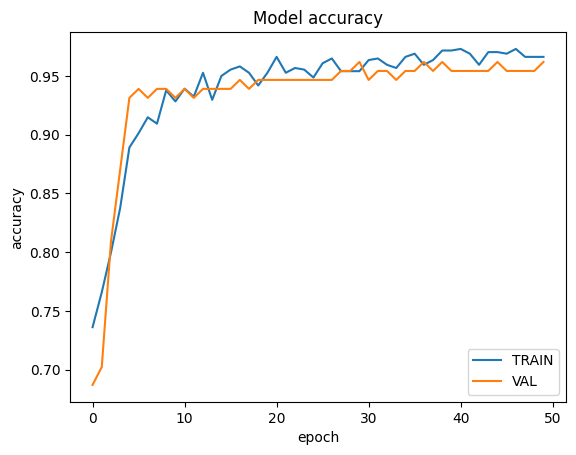

In [52]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [53]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.1070 - accuracy: 0.9794


In [54]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label, y_pred_label))

8/8 [==============================] - 0s 2ms/step

Classification Report:
               precision    recall  f1-score   support

     Average       0.92      0.98      0.95        46
         Bad       1.00      1.00      1.00       166
        Good       0.96      0.87      0.92        31

    accuracy                           0.98       243
   macro avg       0.96      0.95      0.95       243
weighted avg       0.98      0.98      0.98       243



In [55]:
# Convert pose classification model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open(CLASSIFIER, 'wb') as f:
  f.write(tflite_model)

with open(LABELS, 'w') as f:
  f.write('\n'.join(class_names))

INFO:tensorflow:Assets written to: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpffos_7vj/assets


INFO:tensorflow:Assets written to: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpffos_7vj/assets


Model size: 26KB


2023-01-29 22:59:04.013932: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-29 22:59:04.014440: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-29 22:59:04.016264: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpffos_7vj
2023-01-29 22:59:04.020103: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-01-29 22:59:04.020132: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpffos_7vj
2023-01-29 22:59:04.040341: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-01-29 22:59:04.131161: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /var/folders/kj/z6f2hnq53ll7t2pf5jdlhc3h0000gn/T/tmpffos_7vj
2023-01-

In [56]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.9629629629629629
